In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

Siamese Networks can be applied to different use cases, like detecting duplicates, ***finding anomalies***, and face recognition.

We will provide ***three images*** to the model, where two of them will be ***similar*** (anchor and positive samples), and the third will be ***unrelated*** (a negative example.) Our goal is for the model to learn to estimate the similarity between images.

Triplet loss in the FaceNet paper by Schroff et al,. 2015. (https://arxiv.org/pdf/1503.03832.pdf)


#### Triplet Loss
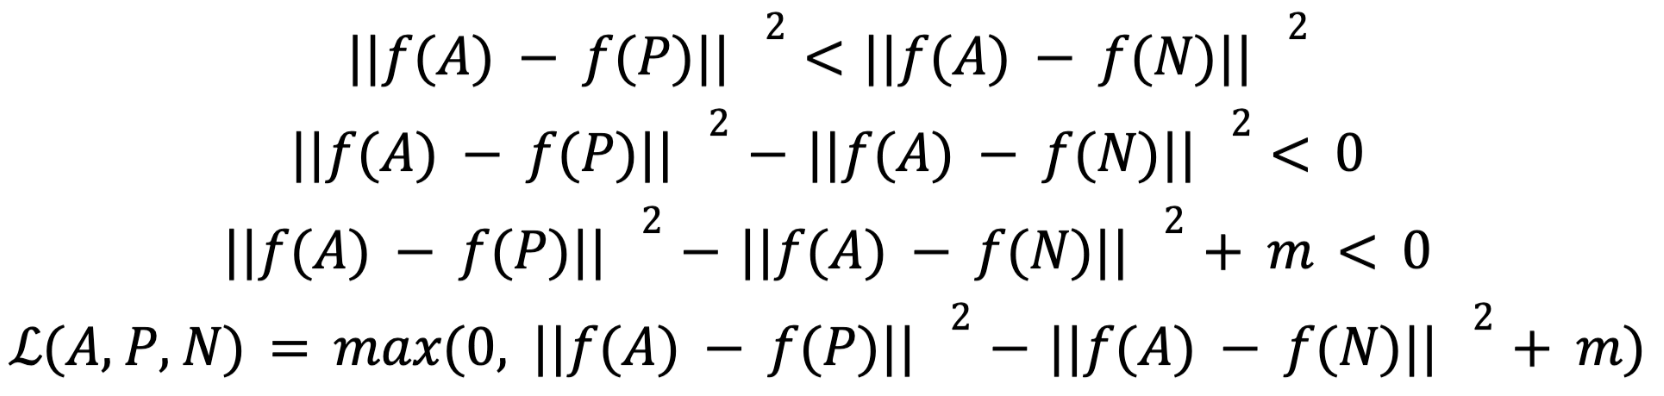

In [2]:
IMG_SIZE = (200, 200)

#### Load Dataset

The dataset consists of two separate files:

* left.zip contains the images that we will use as the anchor.
* right.zip contains the images that we will use as the positive sample (an image that looks like the anchor).

In [3]:
anchor_images_path = "/kaggle/input/totally-looks-like-dataset/left/left"
positive_images_path ="/kaggle/input/totally-looks-like-dataset/right/right"

In [4]:
os.listdir(anchor_images_path)[:5]

['05938.jpg', '04168.jpg', '02371.jpg', '04377.jpg', '00767.jpg']

In [5]:
# Load the specified file as a JPEG image and preprocess it
def preprocess_image(filename, size=None):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)  # Decode a JPEG-encoded image to a uint8 tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    if size != None:
        image = tf.image.resize(image, size)
    return image

In [6]:
# Load and preprocess the three images given the corresponding filenames
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor, IMG_SIZE),
        preprocess_image(positive, IMG_SIZE),
        preprocess_image(negative, IMG_SIZE),
    )

In [7]:
# Visualize a few triplets from the supplied batches
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [8]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted([str(anchor_images_path + "/" + f) for f in os.listdir(anchor_images_path)])

positive_images = sorted([str(positive_images_path + "/" + f) for f in os.listdir(positive_images_path)])

image_count = len(anchor_images)

Setup data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [9]:
# Sorted anchor images
anchor_images[:5]

['/kaggle/input/totally-looks-like-dataset/left/left/00000.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/00001.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/00002.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/00003.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/00004.jpg']

tf.data.Dataset.from_tensor_slices() func returns tensors that are separated with ","

For example: dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

Output: 

tf.Tensor(1, shape=(), dtype=int32)

tf.Tensor(2, shape=(), dtype=int32)

tf.Tensor(3, shape=(), dtype=int32)


dataset = tf.data.Dataset.from_tensor_slices([[4,5,6],[1, 2, 3]])

Output:

tf.Tensor([4 5 6], shape=(3,), dtype=int32)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)

In [ ]:
'''
dataset = tf.data.Dataset.from_tensor_slices([[1, 2, 3], [4,5,6]])
dataset_np = np.stack(list(dataset))
dataset_np

OUTPUT: 
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)


dataset = tf.data.Dataset.from_tensors([[1, 2, 3], [4,5,6]])
dataset_np = np.stack(list(dataset))
dataset_np

OUTPUT:
array([[[1, 2, 3],
        [4, 5, 6]]], dtype=int32)
'''

In [10]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

2022-12-04 17:12:10.699414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 17:12:10.814021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 17:12:10.814888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 17:12:10.817052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)  # We need to apply deterministic randomness for providing to locate the similar images in same indexes
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

In [12]:
print("Shuffled anchor_images: ")
anchor_images[:5]

Shuffled anchor_images: 


['/kaggle/input/totally-looks-like-dataset/left/left/00319.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/02402.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/04472.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/02826.jpg',
 '/kaggle/input/totally-looks-like-dataset/left/left/00084.jpg']

In [13]:
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)
# For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
# If you have a buffer as big as the dataset, you can obtain a uniform shuffle

tf.data.Dataset.zip(): Creates a Dataset by zipping together the given datasets.

For exmaple:

    a = tf.data.Dataset.range(1, 4)  # ==> [ 1, 2, 3 ]

    b = tf.data.Dataset.range(4, 7)  # ==> [ 4, 5, 6 ]

    ds = tf.data.Dataset.zip((a, b))

    list(ds.as_numpy_iterator())

Output: [(1,4),(2,5),(3,6)]

In [14]:
# Creates a Dataset by zipping together the given datasets.
# This method has similar semantics to the built-in zip() function in Python, 
# with the main difference being that the datasets argument can be a (nested) 
# structure of Dataset objects
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)   # Dataset has 3 different image arrays (anchor, positive, negative)

tf.data.Dataset.batch(batch_size, drop_remainder=False, num_parallel_calls=None, deterministic=None, name=None)

For example:

    dataset = tf.data.Dataset.range(8)
    dataset = dataset.batch(3)
    list(dataset.as_numpy_iterator())

Output:

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

In [15]:
# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
# tf.data.Dataset.take(): Creates a Dataset with at most count elements from this dataset
# count: A tf.int64 scalar tf.Tensor, representing the number of elements of this dataset 
# that should be taken to form the new dataset. If count is -1, or if count is greater than 
#the size of this dataset, the new dataset will contain all elements of this dataset.

val_dataset = dataset.skip(round(image_count * 0.8))
# Creates a Dataset that skips count elements from this dataset.
# If count is greater than the size of this dataset or the count is -1, the new dataset will 
# contain no elements

train_dataset = train_dataset.batch(32, drop_remainder=False)  # Optimum batch size is 32
# Combines consecutive elements of this dataset into batches.
# drop_remainder: representing whether the last batch should be dropped in the case it has 
# fewer than batch_size elements; the default behavior is not to drop the smaller batch
train_dataset = train_dataset.prefetch(8)
# Creates a Dataset that prefetches elements from this dataset. Most dataset input pipelines 
# should end with a call to prefetch. This allows later elements to be prepared while the 
# current element is being processed.

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

#### ResNet50
Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ***ResNet50*** model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer ***conv5_block1_out***. This is important to avoid affecting the weights that the model has already learned. We are going to leave the bottom few layers trainable, so that we can fine-tune their weights during training.

Research Residual Neural Networks: https://suhedacilek.medium.com/resnet-residual-network-nedir-49105e642566

Keras available models: https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [16]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=IMG_SIZE + (3,), include_top=False   # (200, 200, 3)
    # include_top parameter lets you to select the final dense layers to be or not
    # Dense layers are capable of interpreting the found features in order to classify

    # input_shape: optional shape tuple, only to be specified if include_top is False 
    # (otherwise the input shape has to be (224, 224, 3).  It should have exactly 3 
    # inputs channels, and width and height should be no smaller than 32. 
    # E.g. (200, 200, 3) would be one valid value.
)

flatten = tf.keras.layers.Flatten()(base_cnn.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
# BN layers make the training faster, and allow a wider range of 
# learning rate without compromising the training convergence
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
output = tf.keras.layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True   # Set layers as trainable after conv5_block1
    layer.trainable = trainable

94781440/94765736 [==============================] - 0s 0us/step


#### Siamese Neural Network Model

The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [ ]:
# This layer is responsible for computing the distance between the anchor
# embedding - positive embedding, and the anchor embedding - negative embedding
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # Triplet Loss: L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    # In Distance Layer: ap_distance = ‖f(A) - f(P)‖², an_distance = ‖f(A) - f(N)‖²
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)  # Return positive and negative pair distances

tf.reduce_sum()

x = tf.constant([[1, 1, 1], [1, 1, 1]])

Output: 

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=

       array([[1, 1, 1],

              [1, 1, 1]], dtype=int32)>


x=tf.reduce_sum(x).numpy()

Output: 

       6

x=tf.reduce_sum(x,0).numpy()

Output: 

       array([2, 2, 2], dtype=int32)



x=tf.reduce_sum(x, 1).numpy()

Output: 

       array([3, 3], dtype=int32)

x=tf.reduce_sum(x, -1).numpy()

Output: 

       array([3, 3], dtype=int32)

Create inputs as keras.layers.Input with names anchor_input, positive_input, and negative_input for feeding the model

In [17]:
# Set Keras Input Layers
anchor_input = layers.Input(name="anchor", shape=IMG_SIZE + (3,))
positive_input = layers.Input(name="positive", shape=IMG_SIZE + (3,))
negative_input = layers.Input(name="negative", shape=IMG_SIZE + (3,))

In [ ]:
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

In [ ]:
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

Customizing a model: https://keras.io/guides/customizing_what_happens_in_fit/

In [18]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)  # List of variables to be included in backpropagation
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

#### Training the model

In [19]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

2022-12-04 17:12:17.203453: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-04 17:12:26.488975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


151/151 [==============================] - 79s 421ms/step - loss: 0.5010 - val_loss: 0.3772
Epoch 2/10
151/151 [==============================] - 48s 317ms/step - loss: 0.3951 - val_loss: 0.3635
Epoch 3/10
151/151 [==============================] - 49s 322ms/step - loss: 0.3816 - val_loss: 0.3459
Epoch 4/10
151/151 [==============================] - 49s 321ms/step - loss: 0.3537 - val_loss: 0.3189
Epoch 5/10
151/151 [==============================] - 49s 321ms/step - loss: 0.3414 - val_loss: 0.3288
Epoch 6/10
151/151 [==============================] - 48s 315ms/step - loss: 0.3239 - val_loss: 0.3251
Epoch 7/10
151/151 [==============================] - 48s 317ms/step - loss: 0.3098 - val_loss: 0.3010
Epoch 8/10
151/151 [==============================] - 48s 316ms/step - loss: 0.3080 - val_loss: 0.3201
Epoch 9/10
151/151 [==============================] - 48s 315ms/step - loss: 0.3012 - val_loss: 0.3043
Epoch 10/10
151/151 [==============================] - 48s 320ms/step - loss: 0.2979

Let's pick a sample from the dataset to check the similarity between the embeddings generated for each image.

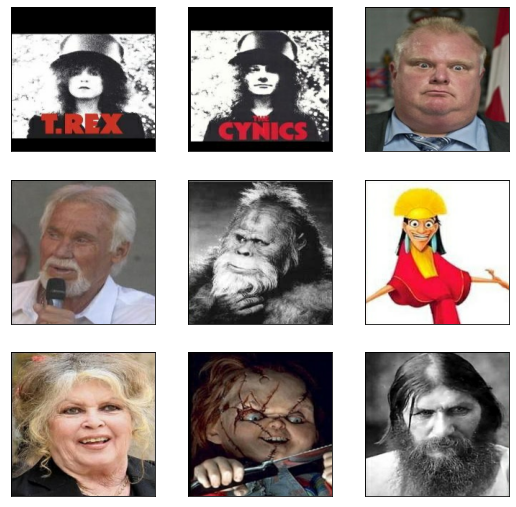

In [23]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [21]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9968695
Negative similarity 0.99560094


### References

This example uses the Totally Looks Like dataset by Rosenfeld et al., 2018.

https://arxiv.org/pdf/1803.01485v3.pdf

https://sites.google.com/view/totally-looks-like-dataset

https://keras.io/examples/vision/siamese_network/

https://levelup.gitconnected.com/metric-learning-using-siamese-and-triplet-convolutional-neural-networks-ed5b01d83be3

Authors: Hazem Essam and Santiago L. Valdarrama

Date created: 2021/03/25

Last modified: 2021/03/25
